In [134]:

import gridworlds           # import to trigger registration of the environment
import gymnasium as gym
import numpy as np

# create instance
env = gym.make("gridworld-v0")
env.reset()

(array([2, 2]), {})

In [135]:
class Policy:
    def __init__(self, exploration_factor = 0.1, gamma=0.9, initial_policy=None):
        
        self.exploration_factor = exploration_factor
        self.gamma=gamma

        if initial_policy ==None:
           self.policy = np.full((5, 5, 4), 0.25)
           #self.policy = np.tile([0.1, 0.1, 0.4, 0.4], (16, 1))
     
        else:
            self.policy=initial_policy
       
        self.N_detailed=np.zeros((25,4,25)) # state, action, next_state, counts visits
        self.Q=np.zeros((25,4)) #
        self.v=np.zeros((25))
        self.Returns=[[] for i in range(25)]
        self.Rewards_cum=np.zeros((25,4))
        self.pos_dict={i*4+j: [i,j] for i in range(4) for j in range(4)}

    def act(self, state):
        # epsilon-greedy
        if np.random.rand() < self.exploration_factor:
            return np.random.choice(4) # random action
        else:
            return np.argmax(self.policy[state[0], state[1]]) # greedy action
    
    
    def update(self, state, action):
        self.policy[state[0], state[1]] = np.zeros(4)
        self.policy[state[0], state[1], action] = 1
    
    
    def eval_episode(self,episode):
        states, actions, rewards= episode 
        next_state=states[-1]
        G=0
        for i, state in reversed(list(enumerate(states[:-1]))):
            action=actions[i]
            reward=rewards[i]
            self.Rewards_cum[state,action]+=reward
            G=self.gamma*G + reward
            self.N_detailed[state,action,next_state]+=1
            if state not in states[:i]:
                self.Returns[state].append(G)
                self.v[state]=sum(self.Returns[state])/len(self.Returns[state])
            next_state=state


    def compute_q(self):
        for state in range(self.Q.shape[0]):
            for action in range(self.Q.shape[1]):

                s_a_visits=np.sum(self.N_detailed[state,action])
                if s_a_visits==0:
                    s_a_visits=1 # dirty solution to avoiding nan values
                probs_s_a=self.N_detailed[state,action]/s_a_visits
                s_a_rewards=self.Rewards_cum[state,action]/s_a_visits
                self.Q[state,action]=np.dot(probs_s_a,self.v)+s_a_rewards

    def improve_policy(self):
        self.compute_q()
        for state in range(self.Q.shape[0]):
            best_action_value=np.max(self.Q[state])
            base=0
            new_probs=np.zeros(4)
            for i, action_value in enumerate(self.Q[state]):
                if action_value== best_action_value:
                    new_probs[i]=1
                    base+=1
            new_probs=new_probs/base
            self.policy[state] = new_probs
        self.Returns=[[] for i in range(16)]
    
    def optimise(self,env,max_iterations, eps_per_iter=100,max_eps_length=100):
        for it in range(max_iterations):
            for eps_nr in range(eps_per_iter):
                env.reset()
                state, _ = env.reset()
                episode=[[state],[],[]]
                for i in range(max_eps_length):
                    action = self.act(state)
                    state, reward, terminated, truncated, _ = env.step(action) 
                    episode[0].append(state)
                    episode[1].append(action)
                    episode[2].append(reward)
                    
                    if terminated or truncated:
                        break
                
                self.eval_episode(episode)
            
            if it % 10 == 0:
                self.improve_policy()
                self.show_heatmap(it)
                self.show_policy(it)
    

In [136]:
import numpy as np
import matplotlib.pyplot as plt

def plot_gridworld(final_value, final_policy):
    fig, ax = plt.subplots()
    im = ax.imshow(final_value, cmap='viridis')

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(5))
    ax.set_yticks(np.arange(5))

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(5):
        for j in range(5):
            text = ax.text(j, i, round(final_value[i, j], 2),
                        ha="center", va="center", color="w")

    ax.set_title("5x5 Gridworld Value Function")
    fig.tight_layout()
    plt.show()
    policy_arrows = {0: '↑', 1: '→', 2: '↓', 3: '←'}

    fig, ax = plt.subplots()
    ax.imshow(final_value, cmap='viridis')

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(5))
    ax.set_yticks(np.arange(5))

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(5):
        for j in range(5):
            best_action = np.argmax(final_policy[i, j])
            text = ax.text(j, i, policy_arrows[best_action],
                        ha="center", va="center", color="w")

    ax.set_title("5x5 Gridworld Optimal Policy")
    fig.tight_layout()
    plt.show()

In [137]:
class TDPolicy:
    def __init__(self,initial_policy=None,gamma=0.9, exploration_factor=0.1):
        self.gamma=gamma
        self.exploration_factor=exploration_factor
        if initial_policy ==None:
           self.policy=np.full((5,5,4),0.25)
     
        else:
            self.policy=initial_policy
       
        self.N_detailed=np.zeros((5,5,4,25))
        self.Q=np.zeros((5,5,4))
        self.v=np.zeros((5,5))
        self.Returns=[[] for i in range(25)]
        self.Rewards_cum=np.zeros((5,5,4))
        self.pos_dict={i*4+j: [i,j] for i in range(25) for j in range(4)}

    def act(self, state):
        # epsilon-greedy
        if np.random.rand() < self.exploration_factor:
            return np.random.choice(4)
        else:
            return np.argmax(self.policy[state[0], state[1]])
        
    
    def improve_policy(self,Q): # Returns the new policy based on the Q values
        self.policy = np.zeros((5, 5, 4))  
        for x in range(5):
            for y in range(5):
                best_action = np.argmax(Q[x, y])
                self.policy[x, y, :] = 0
                self.policy[x, y, best_action] = 1.0
        return self.policy
    def plot_policy(self, policy):
        policy_arrows = {0: '↑', 1: '→', 2: '↓', 3: '←'}

        fig, ax = plt.subplots()
        ax.imshow(policy, cmap='viridis')

        # Show all ticks and label them with the respective list entries
        ax.set_xticks(np.arange(5))
        ax.set_yticks(np.arange(5))

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        for i in range(5):
            for j in range(5):
                best_action = np.argmax(policy[i, j])
                text = ax.text(j, i, policy_arrows[best_action],
                            ha="center", va="center", color="w")

        ax.set_title("5x5 Gridworld Optimal Policy")
        fig.tight_layout()
        plt.show()

In [138]:

def tdn(env, policy, n=1, num_episodes=1000, alpha=0.1):
    V = np.zeros((5,5))
    Q = np.zeros((5,5,4))
    gamma = policy.gamma
    avg_values = []
    final_reward = []

    for i in range(num_episodes): # for each episode
        state = env.reset()
        state = state[0]
        states = [state]
        actions = []
        rewards = []
        done = False
        T = float('inf')
        t = 0
       

  
        while True:
            if t < T: # true for all steps before the terminal step
                action = policy.act(state)
                actions.append(action)
                # print(f'Action is {action}')
                ret = env.step(action)
                next_state = ret[0]
                reward = ret[1]
                done = ret[2]
                # print(f'Next state is {next_state}')
                states.append(next_state)
                rewards.append(reward)
                
                if done:
                    T = t + 1 
            
            tau = t - n + 1 
            if tau >= 0:
                G = sum([gamma**(i-tau-1) * rewards[i] for i in range(tau, min(tau + n, T))]) # calculates n-step return
                if tau + n < T: # if not terminal
                    next_state_x, next_state_y = states[tau + n] # gets the next state
                    G += gamma**n * V[next_state_x, next_state_y] # adds the value of the next state
                state_x, state_y = states[tau]
                action = actions[tau]
                Q[state_x, state_y, action] += alpha * (G - Q[state_x, state_y, action]) # updates Q
                V[state_x, state_y] = np.max(Q[state_x, state_y])
            
            if tau == T - 1:
                break # if the episode is over
            
            t += 1
            state = next_state
        policy.improve_policy(Q)
        avg_values.append(np.mean(V))
        final_reward.append(np.sum(rewards))
    return V, Q, avg_values, final_reward

def plot(V):
    V = np.round(V, 5).reshape(5, 5)
    fig, ax = plt.subplots()
    cax = ax.matshow(V, interpolation='nearest')
    fig.colorbar(cax)

    for (i, j), val in np.ndenumerate(V):
        ax.text(j, i, f'{val:.5f}', ha='center', va='center')

    plt.show()
def plot_learning_curve(avg_values):
    plt.plot(avg_values)
    plt.xlabel('Episode')
    plt.ylabel('Average Value')
    plt.title('Learning Curve')
    plt.show()


In [139]:
def plot_gridworld(final_value, final_policy):
    fig, ax = plt.subplots()
    im = ax.imshow(final_value, cmap='viridis')

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(5))
    ax.set_yticks(np.arange(5))

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(5):
        for j in range(5):
            text = ax.text(j, i, round(final_value[i, j], 2),
                        ha="center", va="center", color="w")

    ax.set_title("5x5 Gridworld Value Function")
    fig.tight_layout()
    plt.show()
    policy_arrows = {0: '↑', 1: '→', 2: '↓', 3: '←'}

    fig, ax = plt.subplots()
    ax.imshow(final_value, cmap='viridis')

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(5))
    ax.set_yticks(np.arange(5))

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(5):
        for j in range(5):
            best_action = np.argmax(final_policy[i, j])
            text = ax.text(j, i, policy_arrows[best_action],
                        ha="center", va="center", color="w")

    ax.set_title("5x5 Gridworld Optimal Policy")
    fig.tight_layout()
    plt.show()

def plot_q_values(Q):
        fig, ax = plt.subplots()
        im = ax.imshow(np.max(Q, axis=2), cmap='viridis')

        # Show all ticks and label them with the respective list entries
        ax.set_xticks(np.arange(5))
        ax.set_yticks(np.arange(5))

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        for i in range(5):
            for j in range(5):
                for k, (dx, dy) in enumerate([(0, -0.3), (0.3, 0), (0, 0.3), (-0.3, 0)]):
                    text = ax.text(j + dy, i + dx, round(Q[i, j,3 - k], 2),
                    ha="center", va="center", color="w")

        ax.set_title("5x5 Gridworld Q-Values")
        fig.tight_layout()
        plt.show()

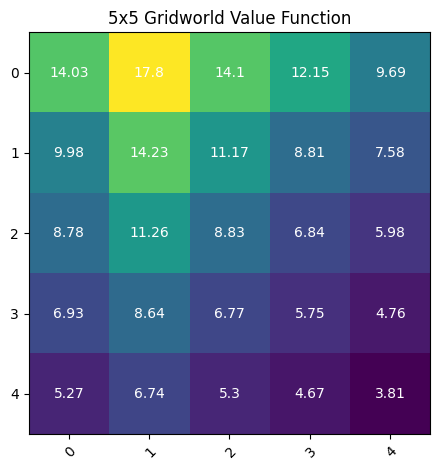

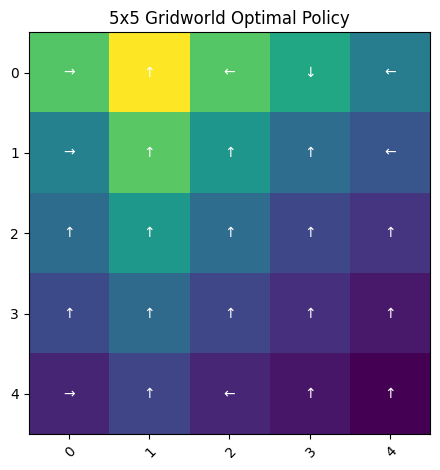

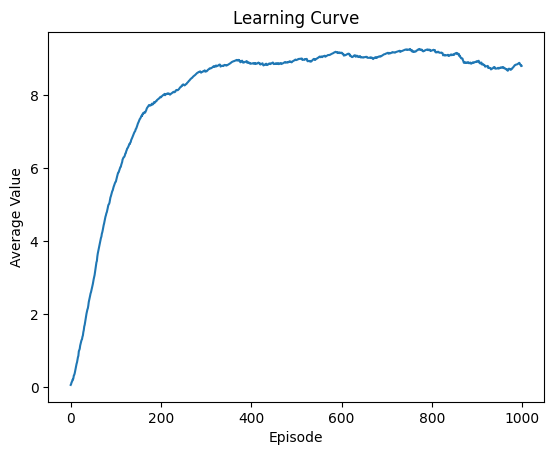

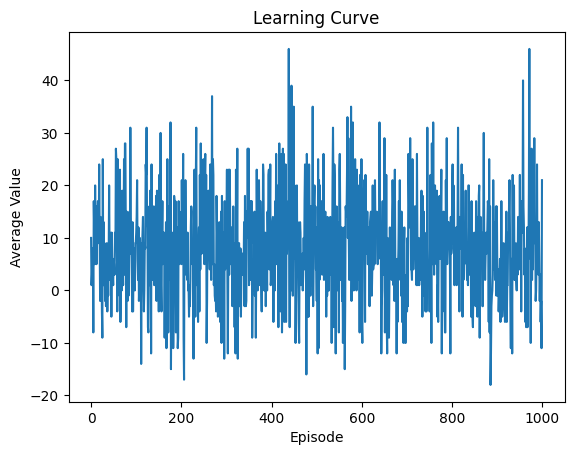

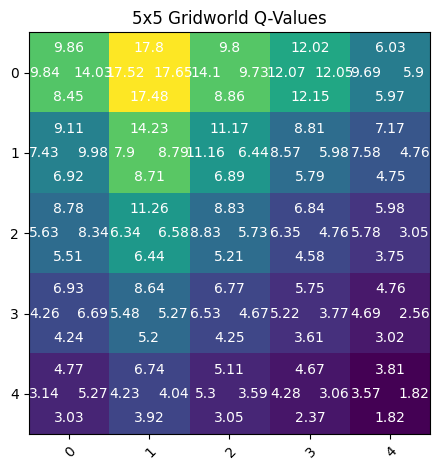

In [140]:
pol = TDPolicy(exploration_factor=0.9, gamma = 0.8)
V = tdn(env, pol, num_episodes=1000, alpha=0.1, n=1)
# print(pol.policy)
# pol.plot_policy(pol.policy)
# # print(V[2])
# plot(V[0])
plot_gridworld(V[0], V[1])
plot_learning_curve(V[2])
plot_learning_curve(V[3])
plot_q_values(V[1])


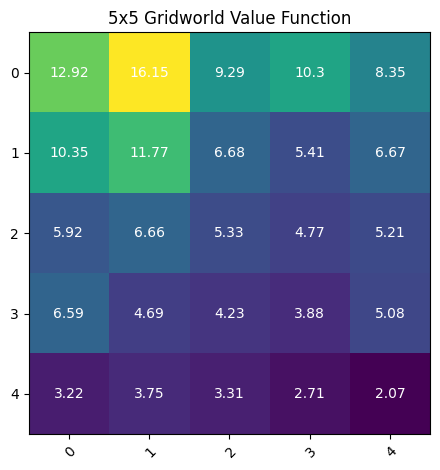

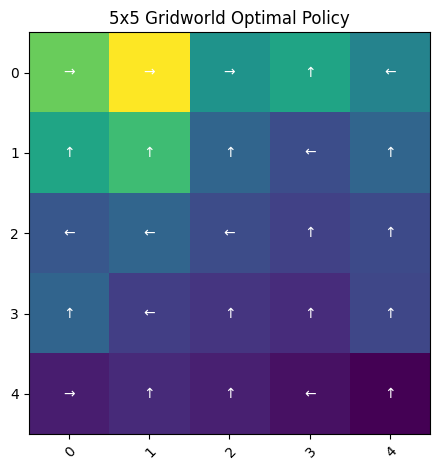

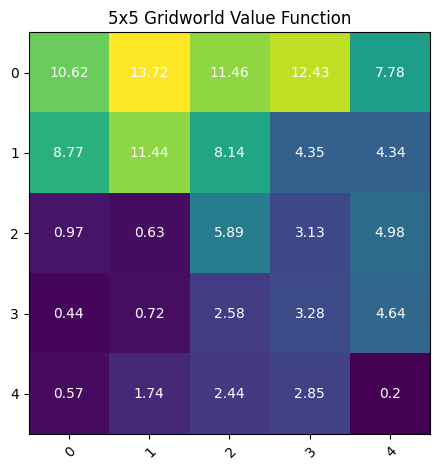

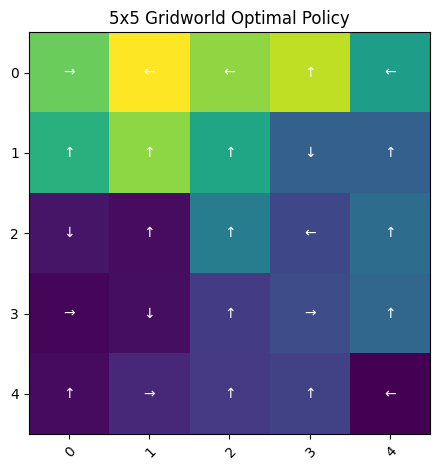

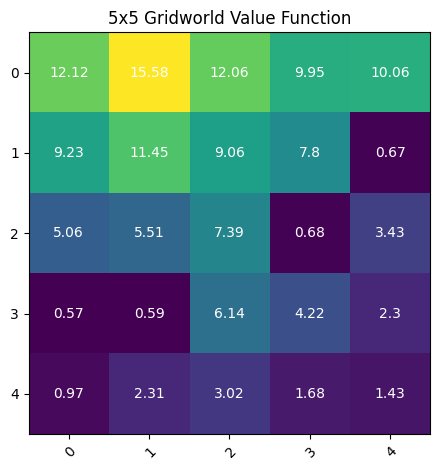

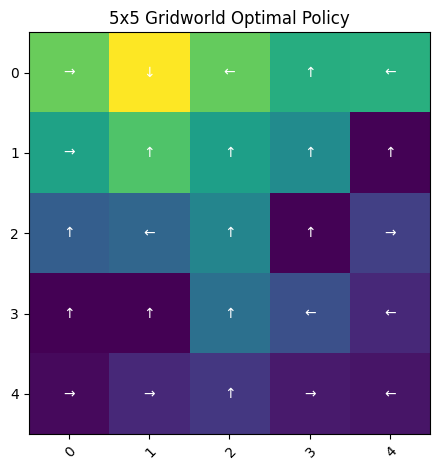

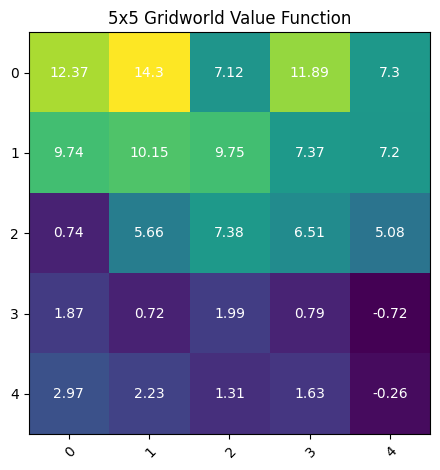

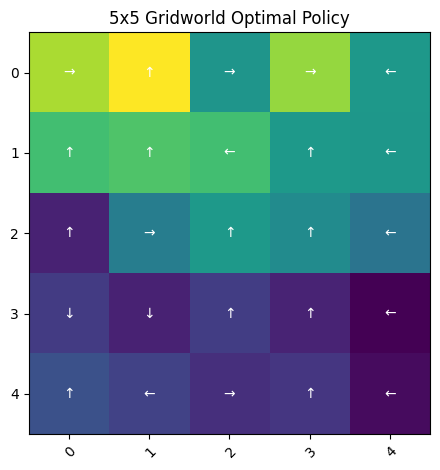

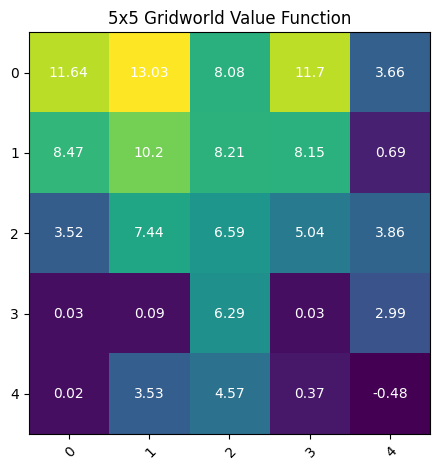

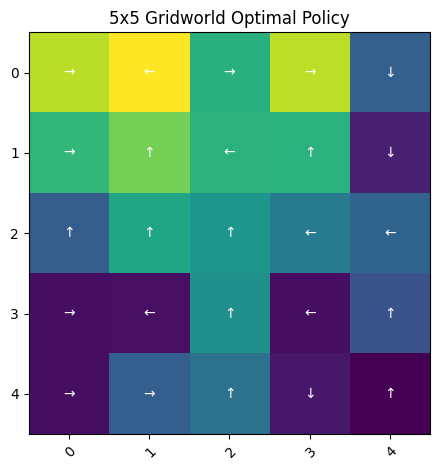

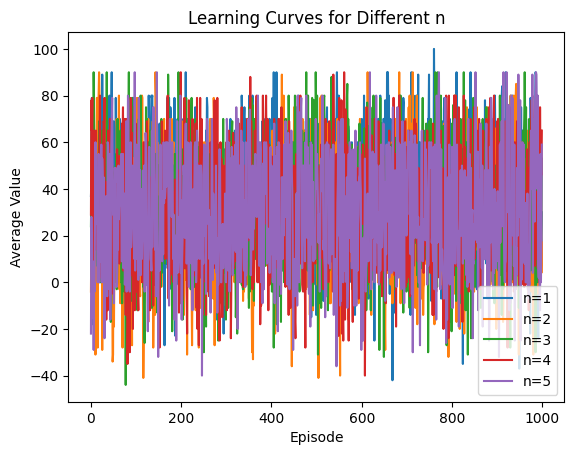

In [144]:
def plot_learning_curves(avg_values_list, n_values, title='Learning Curves for Different n'):
    for avg_values, n in zip(avg_values_list, n_values):
        plt.plot(avg_values, label=f'n={n}')
    plt.xlabel('Episode')
    plt.ylabel('Average Value')
    plt.title(title)
    plt.legend()
    plt.show()
V_1 = tdn(env, TDPolicy(exploration_factor=0.2, gamma = 0.8), num_episodes=1000, alpha=0.9, n=1)
plot_gridworld(V_1[0], V_1[1])
V_2 = tdn(env, TDPolicy(exploration_factor=0.2, gamma = 0.8), num_episodes=1000, alpha=0.9, n=2)
plot_gridworld(V_2[0], V_2[1])
V_3 = tdn(env, TDPolicy(exploration_factor=0.2, gamma = 0.8), num_episodes=1000, alpha=0.9, n=3)
plot_gridworld(V_3[0], V_3[1])
V_4 = tdn(env, TDPolicy(exploration_factor=0.2, gamma = 0.8), num_episodes=1000, alpha=0.9, n=4)
plot_gridworld(V_4[0], V_4[1])
V_5 = tdn(env, TDPolicy(exploration_factor=0.2, gamma = 0.8), num_episodes=1000, alpha=0.9, n=5)
plot_gridworld(V_5[0], V_5[1])
# plot_q_values(V_50[1])
plot_learning_curves([V_1[3], V_2[3], V_3[3], V_4[3], V_5[3]], [1, 2, 3, 4, 5])

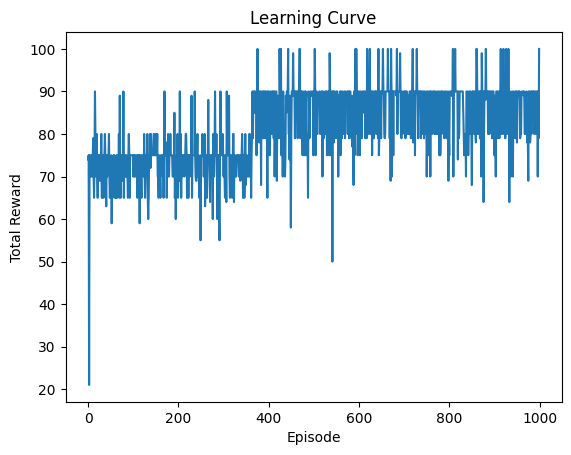

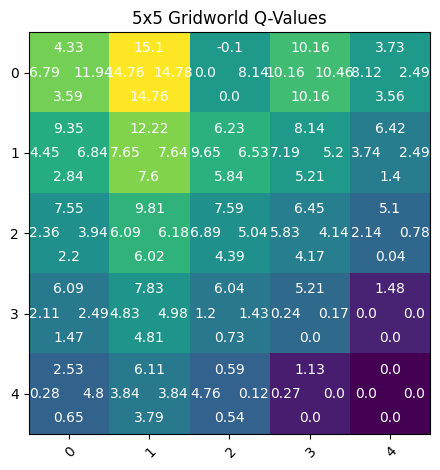

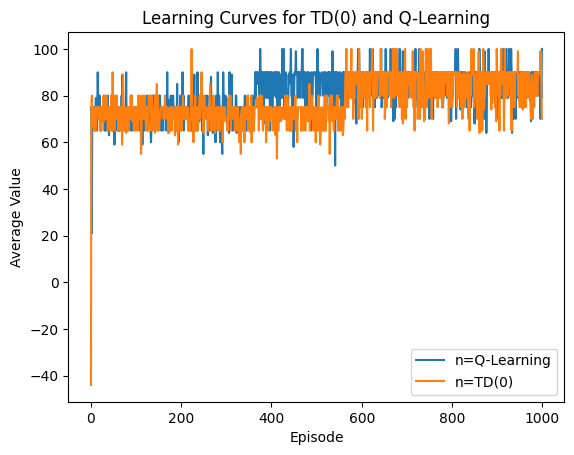

In [143]:

class QLearningPolicy:
    def __init__(self, gamma=0.9, epsilon=0.1):
        self.gamma = gamma
        self.epsilon = epsilon
        
        self.Q = np.zeros((5, 5, 4))

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(4)
        else:
            return np.argmax(self.Q[state[0], state[1]])

    def update(self, state, action, reward, next_state, alpha):
        best_next_action = np.argmax(self.Q[next_state[0], next_state[1]])
        td_target = reward + self.gamma * self.Q[next_state[0], next_state[1], best_next_action]
        td_error = td_target - self.Q[state[0], state[1], action]
        self.Q[state[0], state[1], action] += alpha * td_error

def q_learning(env, policy, num_episodes=1000, alpha=0.1):
    avg_values = []

    for i in range(num_episodes):
        state = env.reset()
        state = state[0]
        done = False
        total_reward = 0

        while not done:
            action = policy.act(state)
            ret = env.step(action)
            next_state = ret[0]
            reward = ret[1]
            done = ret[2]
            policy.update(state, action, reward, next_state, alpha)
            state = next_state
            total_reward += reward

        avg_values.append(total_reward)

    return policy.Q, avg_values

def plot_learning_curve(avg_values):
    plt.plot(avg_values)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Learning Curve')
    plt.show()


policy = QLearningPolicy(gamma=0.8, epsilon=0.1)
Q, avg_values1 = q_learning(env, policy, num_episodes=1000, alpha=0.1)
plot_learning_curve(avg_values1)
plot_q_values(Q)
policy_td = TDPolicy(exploration_factor=0.1, gamma=0.8)
V, Q, avg_values, final_reward = tdn(env, policy_td, num_episodes=1000, alpha=0.1)

plot_learning_curves([avg_values1, final_reward], ["Q-Learning","TD(0)"], title='Learning Curves for TD(0) and Q-Learning')
